In [1]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

# Hierarchichal training

In our case we can make problem gradually more difficult to solve, while keeping the the `A` matrix in exactly the same shape. This should allow us to use the same `ResGCN`

- First way is to increase the scale of the filter, as the bigger scacle the worse is the conditioning of the matrix. 
- Second is increasing the order of the filer `n`, which makes much more difficult to solve the problem
---

To start we have to generate sythetic problem of given size

In [2]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

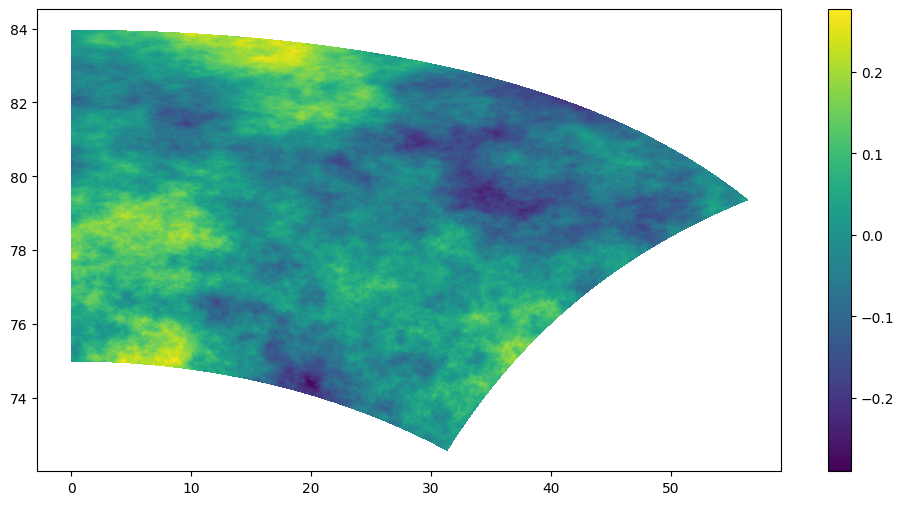

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

Now lets define model parameters 

In [4]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

Now we need to create scales that we want to use

In [5]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [6]:
tt.shape

(251001,)

Now we define the matricies for model to learn preconditioning

In [7]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

/tmp/ipykernel_3045178/641305269.py:9: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)


Now model can be initialized for the first phase of training

In [8]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

As a test we will solve the problem without preconditioner 

In [9]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=19999, progress_bar=True)
    print("Iteration " + str(iters))
    iterations[i] = iters

Solve:   1%|          | 138/19999 [00:00<01:38, 201.16it/s]


Iteration 138


Solve:   2%|▏         | 349/19999 [00:00<00:35, 549.96it/s]


Iteration 349


Solve:   5%|▍         | 915/19999 [00:01<00:34, 551.04it/s]


Iteration 915


Solve:  13%|█▎        | 2507/19999 [00:04<00:31, 546.94it/s]


Iteration 2507


Solve:  35%|███▌      | 7076/19999 [00:12<00:23, 547.97it/s]


Iteration 7076


Solve:  99%|█████████▊| 19707/19999 [00:35<00:00, 548.04it/s]


Iteration 19707


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 547.12it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 547.85it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 546.06it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 545.92it/s]

Iteration 19999


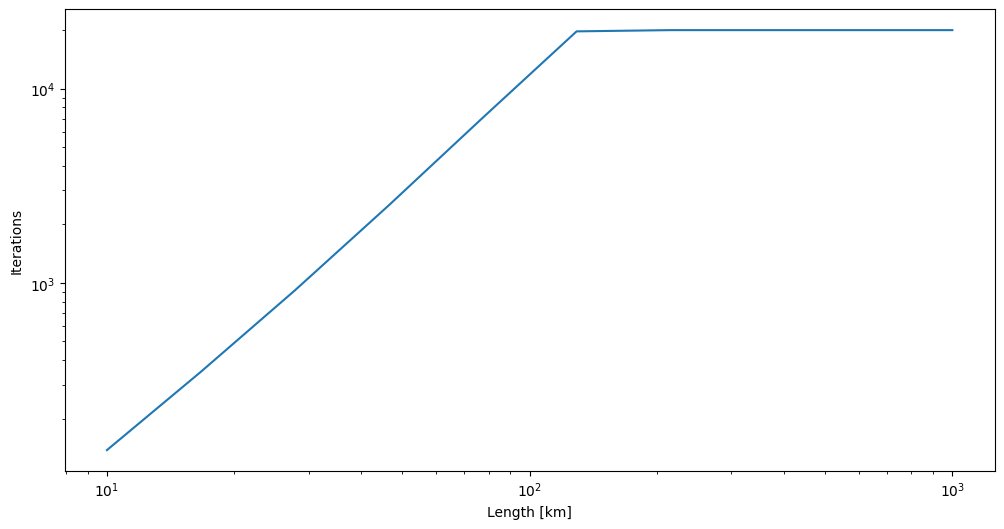

In [10]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

In [11]:
#INTRODUCING MORE PHASES, EACH WITH VARIABLE EPOCHS

In [12]:
PHASES = 1000            # one can set this as you like (e.g., 50, 200, 1000)
EPOCHS_PER_PHASE = 2
CKPT_DIR = "./ckpt_task12/"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0



num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 40                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 



EPOCHS_PER_PHASE_BASE = int(max(1, EPOCHS_PER_PHASE))
M_BASE                = int(max(1, m))
BATCH_BASE            = int(max(1, batch_size))

GROWTH_EPOCHS = 1.15     # epochs per Ai grows ~15% each phase
GROWTH_M      = 1.10     # m grows ~10% each phase
GROWTH_BATCH  = 1.20     # batch grows ~20% each phase

MAX_EPOCHS_PER_PHASE = 10
MAX_M                = 640
MAX_BATCH            = 32

print(f"[Task 2] PHASES={PHASES}, base epochs/phase={EPOCHS_PER_PHASE_BASE}")
print(f"[Task 1] growth: epochs×{GROWTH_EPOCHS}, m×{GROWTH_M}, batch×{GROWTH_BATCH}")
print(f"[caps] epochs≤{MAX_EPOCHS_PER_PHASE}, m≤{MAX_M}, batch≤{MAX_BATCH}")



[Task 2] PHASES=1000, base epochs/phase=2
[Task 1] growth: epochs×1.15, m×1.1, batch×1.2
[caps] epochs≤10, m≤640, batch≤32


In [13]:
# Tasks 1+2 training: many phases with per-phase growth (larger iterations) 
import os, time, torch, numpy as np

# Safety checks
assert 'As' in globals() and isinstance(As, list) and len(As) > 0, "Build As first."
assert 'data' in globals(), "Define `data` before this cell."
assert 'solver' in globals(), "Define `solver` (GMRES) before this cell."
for name in ['PHASES','EPOCHS_PER_PHASE_BASE','M_BASE','BATCH_BASE',
             'GROWTH_EPOCHS','GROWTH_M','GROWTH_BATCH','MAX_EPOCHS_PER_PHASE','MAX_M','MAX_BATCH',
             'CKPT_DIR','SAVE_BEST_EACH_PASS','RESUME_FROM_PHASE','disable_scale_input',
             'num_layers','embed','hidden','drop_rate','dtype','lr','weight_decay',
             'training_data','grad_accu_steps','device','m','batch_size']:
    assert name in globals(), f"Missing required variable: {name}"

net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0  # avoid os.fork() warnings with JAX multithreading

t0_all = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # Task 1 growth for this phase
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    m_now      = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== PHASE {phase+1}/{PHASES} === [epochs/ai={epochs_now}, batch={batch_now}, m={m_now}]")
    M.m = m_now

    tic_phase = time.time()
    for i, Ai in enumerate(As):
        M.A = Ai
        ckpt_prefix = os.path.join(CKPT_DIR, f"p{phase:04d}_Ai{i:03d}_")

        # Train this Ai
        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now,
            grad_accu_steps,
            epochs_now,
            optimizer,
            scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=ckpt_prefix if SAVE_BEST_EACH_PASS else None,
            progress_bar=False
        )

        # Reload best 
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            reloaded = False
            for wpath in candidates:
                if os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    if isinstance(M.net, torch.nn.Module):
                        M.net.load_state_dict(state)
                    reloaded = True
                    break
            if not reloaded:
                print(f"   [warn] No checkpoint found for Ai {i:03d} at "
                      f"{' / '.join(candidates)} — continuing without reload.")

        try:
            init_loss = float(hist_loss[0]); final_loss = float(hist_loss[-1])
        except Exception:
            init_loss, final_loss = np.nan, np.nan
        print(f"   Ai {i:03d} | init={init_loss:.4e}, final={final_loss:.4e}, "
              f"best={best_loss:.4e} at epoch {best_epoch}")

    print(f"[phase {phase+1}] done in {time.time() - tic_phase:.2f} s")
    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))

print(f"\n[Tasks 1+2] Completed {PHASES-RESUME_FROM_PHASE} phases in {time.time()-t0_all:.2f} s.")



=== PHASE 1/1000 === [epochs/ai=2, batch=4, m=80]
   Ai 000 | init=1.0382e-01, final=1.0304e-01, best=1.0304e-01 at epoch 1
   Ai 001 | init=1.0322e-01, final=1.0166e-01, best=1.0166e-01 at epoch 1
   Ai 002 | init=1.0099e-01, final=1.0018e-01, best=1.0018e-01 at epoch 1
   Ai 003 | init=1.0075e-01, final=9.8459e-02, best=9.8459e-02 at epoch 1
   Ai 004 | init=9.8820e-02, final=9.7208e-02, best=9.7208e-02 at epoch 1
   Ai 005 | init=9.6927e-02, final=9.3936e-02, best=9.3936e-02 at epoch 1
   Ai 006 | init=9.4194e-02, final=9.0845e-02, best=9.0845e-02 at epoch 1
   Ai 007 | init=9.0134e-02, final=8.5861e-02, best=8.5861e-02 at epoch 1
   Ai 008 | init=8.5945e-02, final=8.0886e-02, best=8.0886e-02 at epoch 1
   Ai 009 | init=8.1085e-02, final=7.5152e-02, best=7.5152e-02 at epoch 1
[phase 1] done in 6.75 s

=== PHASE 2/1000 === [epochs/ai=2, batch=5, m=88]
   Ai 000 | init=8.9034e-02, final=8.0527e-02, best=8.0527e-02 at epoch 1
   Ai 001 | init=7.9683e-02, final=7.0056e-02, best=7.0056e

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.51 GiB. GPU 0 has a total capacity of 79.25 GiB of which 1.43 GiB is free. Including non-PyTorch memory, this process has 77.82 GiB memory in use. Of the allocated memory 76.54 GiB is allocated by PyTorch, and 764.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
iterations_tasks12 = np.zeros(len(As))
for i, Ai in enumerate(As):
    ttw = data - Ai @ data
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    iterations_tasks12[i] = iters

plt.figure()
#plt.plot(np.logspace(1, 3, 10), iterations,         label="No preconditioner")
#plt.plot(np.logspace(1, 3, 10), iterations_pre,     label="One phase of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post,    label="10 phases of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post100, label="100 phases of training")
plt.plot(np.logspace(1, 3, 10), iterations_tasks12, label=f"{PHASES} phases (with growth)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()


In [14]:
# Unified config: Tasks 1 + 2 + 3 



num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 40                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 


# Total number of phases (Task 2)
PHASES = 1000

# Task 1: growth starting points
EPOCHS_PER_PHASE_BASE = 2     
M_BASE                = m     
BATCH_BASE            = batch_size

# Growth factors per phase (Task 1)
GROWTH_EPOCHS = 1.15
GROWTH_M      = 1.10
GROWTH_BATCH  = 1.20

# Caps (safety)
MAX_EPOCHS_PER_PHASE = 10
MAX_M                = M_BASE * 8
MAX_BATCH            = BATCH_BASE * 8

# Task 3: loopbacks
LOOPBACK_EVERY = 5    # after every 5 phases, run a loopback sweep
LOOPBACK_EPOCHS = 1   # tiny number of epochs during loopback

# Checkpointing
CKPT_DIR = "./ckpt_unified/"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0

print(f"[Unified Config] PHASES={PHASES}, start epochs={EPOCHS_PER_PHASE_BASE}, m={M_BASE}, batch={BATCH_BASE}")
print(f"[Growth] g_epochs={GROWTH_EPOCHS}, g_m={GROWTH_M}, g_batch={GROWTH_BATCH}")
print(f"[Loopback] every {LOOPBACK_EVERY} phases, epochs/ai={LOOPBACK_EPOCHS}")


[Unified Config] PHASES=1000, start epochs=2, m=80, batch=4
[Growth] g_epochs=1.15, g_m=1.1, g_batch=1.2
[Loopback] every 5 phases, epochs/ai=1


In [15]:
# Unified training loop: Tasks 1+2+3 (growth + many phases + loopbacks) 
import os, time, torch, numpy as np

assert 'As' in globals() and isinstance(As, list) and len(As) > 0
assert 'data' in globals()
assert 'solver' in globals()

net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

def train_subset(A_list, epochs_per_ai, phase_tag, batch_now, m_now):
    """Train sequentially on a list of As with given epochs/batch/m."""
    M.m = m_now
    for i, Ai in enumerate(A_list):
        M.A = Ai
        ckpt_prefix = os.path.join(CKPT_DIR, f"{phase_tag}_Ai{i:03d}_")
        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_per_ai,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=ckpt_prefix if SAVE_BEST_EACH_PASS else None,
            progress_bar=False
        )
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    M.net.load_state_dict(state)
                    break
        
        try:
            init_loss = float(hist_loss[0]); final_loss = float(hist_loss[-1])
        except Exception:
            init_loss, final_loss = np.nan, np.nan
        print(f"      Ai | init={init_loss:.4e}, final={final_loss:.4e}, best={best_loss:.4e} @ epoch {best_epoch}")

# Training across all phases 
t0_all = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # Task 1 growth (scaled with phase index)
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    m_now      = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== Phase {phase+1}/{PHASES} === [epochs/ai={epochs_now}, batch={batch_now}, m={m_now}]")
    tic_phase = time.time()
    train_subset(As, epochs_now, phase_tag=f"p{phase:04d}", batch_now=batch_now, m_now=m_now)
    print(f"[phase {phase+1}] done in {time.time() - tic_phase:.2f} s")

    # Task 3 loopback: after every LOOPBACK_EVERY phases
    if (phase + 1) % LOOPBACK_EVERY == 0:
        print(f"   >> Loopback after phase {phase+1} (epochs/ai={LOOPBACK_EPOCHS})")
        tic_lb = time.time()
        train_subset(As, LOOPBACK_EPOCHS, phase_tag=f"loopback_p{phase:04d}", batch_now=batch_now, m_now=m_now)
        print(f"   Loopback time: {time.time() - tic_lb:.2f} s")

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))

print(f"\n[Unified Training] Completed {PHASES} phases in {time.time() - t0_all:.2f} s.")



=== Phase 1/1000 === [epochs/ai=2, batch=4, m=80]


OutOfMemoryError: CUDA out of memory. Tried to allocate 492.00 MiB. GPU 0 has a total capacity of 79.25 GiB of which 475.50 MiB is free. Including non-PyTorch memory, this process has 78.78 GiB memory in use. Of the allocated memory 77.74 GiB is allocated by PyTorch, and 514.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
iterations_unified = np.zeros(len(As))
for i, Ai in enumerate(As):
    ttw = data - Ai @ data
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    iterations_unified[i] = iters

plt.figure()
plt.plot(np.logspace(1, 3, 10), iterations_unified, label=f"{PHASES} phases (growth + loopbacks)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()


In [ ]:
# Approach to truncate at max_iters and recover actual plot 

In [ ]:
#iterations = []
#valid_lengths = []

#max_iters = 19999
#rtol = 1e-6

#for i in range(len(As)):
    #ttw = data - As[i] @ data
    #x, iters, abs_res, rel_res, _ = solver.solve(
    #    A=As[i], b=ttw, rtol=rtol, max_iters=max_iters, progress_bar=False
    #)

    #final_residual = rel_res[-1]
    #print(f"Length {lengths[i]}: {iters} steps, final relres = {final_residual:.2e}")

    # Stop adding once solver doesn't converge
#    if final_residual > rtol or iters == max_iters:
 #       print(f"Stopped at index {i}: did not converge.")
  #      break

   # iterations.append(iters)
    #valid_lengths.append(lengths[i])

#plt.figure(figsize=(6, 4))
#plt.plot(truncated_lengths, iterations, marker='o')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel("Length [km]", fontsize=10)
#plt.ylabel("Iterations", fontsize=10)
#plt.title("Solver Convergence vs. Problem Scale", fontsize=11)
#plt.grid(True, which='both', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()


Now we can only solver problems up to 200 km. Now we run first phase of training 

In [ ]:
#import time 

#tic = time.time()
#hist_loss, best_loss, best_epoch, model_file = M.train(
#    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
#    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
#M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))
#
#print(f'Done. Training time: {time.time()-tic} seconds')
#print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')

# With preconditioner for the sample problem

In [ ]:
#iterations_pre = np.zeros(len(As))
#
#for i in range(len(As)):
#    ttw = data - As[i] @ data  # Work with perturbations
#    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
#    print("Iteration " + str(iters))
#    iterations_pre[i] = iters

In [ ]:
#plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
#plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")
#
#plt.xlabel("Length [km]")
#plt.ylabel("Iterations")
#plt.xscale("log")
#plt.yscale("log")
#plt.legend()
    

# Not great, not terrible. Now let's try training for larger scales, but we reduce amount of time we spend on each case

In [ ]:
#! rm ./*.pt

I reduced number of epochs so the total training budget is the same as for 1 phase

In [ ]:
#net = ResGCN(As[0], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
#optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler = None
#M = GNP(A, training_data, m, net, device)

#for A in As: 
#    M.A = A
#    hist_loss, best_loss, best_epoch, model_file = M.train(
#    batch_size, grad_accu_steps, epochs // 10, optimizer, scheduler, num_workers=4, 
#    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
#    M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))
#    print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
    

In [ ]:
#iterations_post = np.zeros(len(As))
#
#for i in range(len(As)):
#    ttw = data - As[i] @ data  # Work with perturbations
#    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
#    print("Iteration " + str(iters))
#    iterations_post[i] = iters

In [ ]:
# --- 100 phases, same style as Cell 26 ---
#net100 = ResGCN(As[0], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
#optimizer100 = torch.optim.Adam(net100.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler100 = None
#M100 = GNP(A, training_data, m, net100, device)

# keep total budget ~ epochs
#epochs_per_phase_100 = max(1, epochs // 100)

#for phase in range(100):
#    for Ai in As:
#        M100.A = Ai
#        hist_loss, best_loss, best_epoch, model_file = M100.train(
#            batch_size, grad_accu_steps, epochs_per_phase_100,
#            optimizer100, scheduler100, num_workers=4,
#            checkpoint_prefix_with_path="./tmp100_", progress_bar=False
#        )
#        # load best weights for this (sub)phase and carry forward
#        M100.net.load_state_dict(torch.load(
#            f"./tmp100_epoch_{best_epoch}.pt",
#            map_location=device, weights_only=True
#        ))
#    print(f"Completed phase {phase+1}/100: best_loss = {best_loss}, best_epoch = {best_epoch}")

# Evaluate GMRES iterations with the 100-phase preconditioner
#iterations_post100 = np.zeros(len(As))
#for i in range(len(As)):
#    ttw = data - As[i] @ data  # Work with perturbations
#    x, iters, _, _, _ = solver.solve(
#        A=As[i], b=ttw, rtol=1e-6, max_iters=20000,
#        progress_bar=True, M=M100
#    )
#    print("Iteration (100 phases) " + str(iters))
#    iterations_post100[i] = iters


In [ ]:
#plt.figure()
#plt.plot(np.logspace(1, 3, 10), iterations,       label="No preconditioner")
#plt.plot(np.logspace(1, 3, 10), iterations_pre,   label="One phase of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post,  label="10 phases of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post100, label="100 phases of training")
#
#plt.xlabel("Length [km]")
#plt.ylabel("Iterations")
#plt.xscale("log")
#plt.yscale("log")
#plt.legend()


In [ ]:
### Condition Number Plot ###

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
import os
import numpy as np
from tqdm import tqdm

def scale_A_by_spectral_radius(A):

    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA


class Arnoldi():
    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)

        V = torch.zeros(n, m + 1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m + 1, m, dtype=A.dtype).to(A.device)

        V[:, 0] = v0 / beta
        for j in range(m):
            w = A @ V[:, j]
            for k in range(j + 1):
                H[k, j] = torch.dot(V[:, k], w)
                w = w - H[k, j] * V[:, k]
            H[j + 1, j] = torch.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        Vm1 = V
        barHm = H
        return Vm1, barHm


# The following class implements a streaming dataset, which, in combined use with the dataloader, produces x of size (n,batch_size). x is float64 and stays in cpu. It will be moved to the 
# device and cast to a lower precision for training.
class StreamingDataset(IterableDataset):

    # A is torch tensor, either sparse or full
    def __init__(self, A, batch_size, training_data, m):
        super().__init__()
        self.n = A.shape[0]
        self.m = m
        self.batch_size = batch_size
        self.training_data = training_data

        # Computations done in device
        if training_data == 'x_subspace' or training_data == 'x_mix':
            arnoldi = Arnoldi()
            Vm1, barHm = arnoldi.build(A, m=m)
            W, S, Zh = torch.linalg.svd(barHm, full_matrices=False)
            Q = (Vm1[:, :-1] @ Zh.T) / S.view(1, m)
            self.Q = Q.to('cpu')

    def generate(self):
        while True:

            # Computation done in cpu
            if self.training_data == 'x_normal':

                x = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield x

            elif self.training_data == 'x_subspace':

                e = torch.normal(0, 1, size=(self.m, self.batch_size),
                                 dtype=torch.float64)
                x = self.Q @ e
                yield x

            elif self.training_data == 'x_mix':

                batch_size1 = self.batch_size // 2
                e = torch.normal(0, 1, size=(self.m, batch_size1),
                                 dtype=torch.float64)
                x = self.Q @ e
                batch_size2 = self.batch_size - batch_size1
                x2 = torch.normal(0, 1, size=(self.n, batch_size2),
                                  dtype=torch.float64)
                x = torch.cat([x, x2], dim=1)
                yield x

            else:  # self.training_data == 'no_x'

                b = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield b

    def __iter__(self):
        return iter(self.generate())


class GNP():

    # A is torch tensor, either sparse or full
    def __init__(self, A, training_data, m, net, device):
        self.A = A
        self.training_data = training_data
        self.m = m
        self.net = net
        self.device = device
        self.dtype = net.dtype

    def train(self, batch_size, grad_accu_steps, epochs, optimizer,
              scheduler=None, num_workers=0, checkpoint_prefix_with_path=None,
              progress_bar=True):

        self.net.train()
        optimizer.zero_grad()
        dataset = StreamingDataset(self.A, batch_size,
                                   self.training_data, self.m)
        loader = DataLoader(dataset, num_workers=num_workers, pin_memory=True)

        hist_loss = []
        best_loss = np.inf
        best_epoch = -1
        checkpoint_file = None

        if progress_bar:
            pbar = tqdm(total=epochs, desc='Train')

        for epoch, x_or_b in enumerate(loader):

            # Generate training data
            if self.training_data != 'no_x':
                x = x_or_b[0].to(self.device)
                b = self.A @ x
                b, x = b.to(self.dtype), x.to(self.dtype)
            else:  # self.training_data == 'no_x'
                b = x_or_b[0].to(self.device).to(self.dtype)

            # Train
            x_out = self.net(b)
            b_out = (self.A @ x_out.to(torch.float64)).to(self.dtype)
            loss = F.l1_loss(b_out, b)

            # Bookkeeping
            hist_loss.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch
                if checkpoint_prefix_with_path is not None:
                    checkpoint_file = checkpoint_prefix_with_path + 'best.pt'
                    torch.save(self.net.state_dict(), checkpoint_file)

            # Train (cont.)
            loss.backward()
            if (epoch + 1) % grad_accu_steps == 0 or epoch == epochs - 1:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            # Bookkeeping (cont.)
            if progress_bar:
                pbar.set_description(f'Train loss {loss:.1e}')
                pbar.update()
            if epoch == epochs - 1:
                break

        # Bookkeeping (cont.)
        if checkpoint_file is not None:
            checkpoint_file_old = checkpoint_file
            checkpoint_file = \
                checkpoint_prefix_with_path + f'epoch_{best_epoch}.pt'
            os.rename(checkpoint_file_old, checkpoint_file)

        return hist_loss, best_loss, best_epoch, checkpoint_file

    @torch.no_grad()
    def apply(self, r):  # r: float64
        self.net.eval()
        # r = r.to(self.dtype)  # -> lower precision
        r = r.view(-1, 1)
        z = self.net(r)
        z = z.view(-1)
        # z = z.double()  # -> float64
        return z






import torch
import numpy as np
import matplotlib.pyplot as plt
import GNP

condition_numbers = []
epochs_tracked = []

dataset = StreamingDataset(A, batch_size=batch_size,
                           training_data=training_data, m=m)
loader = iter(torch.utils.data.DataLoader(dataset, num_workers=0, batch_size=None))

log_intervals = 20  
interval = 3000 // log_intervals

print("Tracking condition number during training evaluation...")

for i in range(log_intervals + 1):
    epoch = i * interval
    x_or_b = next(loader)

    if training_data != 'no_x':
        x = x_or_b.to(device)
        b = A @ x
        b, x = b.to(net.dtype), x.to(net.dtype)
    else:
        b = x_or_b.to(device).to(net.dtype)

    with torch.no_grad():
        x_out = net(b)

    try:
        ratio = torch.linalg.lstsq(x_out.double(), b.double()).solution
        cond = np.linalg.cond(ratio.cpu().numpy())
        condition_numbers.append(cond)
        epochs_tracked.append(epoch)
        print(f"Epoch {epoch:4d}: Condition number = {cond:.2e}")
    except Exception as e:
        print(f"Failed at epoch {epoch}: {e}")
        condition_numbers.append(np.nan)
        epochs_tracked.append(epoch)

plt.figure(figsize=(8, 5))
plt.plot(epochs_tracked, condition_numbers, marker='o')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Estimated Condition Number")
plt.title("Condition Number Evolution During Training")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [ ]:
# improve preconditioned iterations lower

In [ ]:
# not during training, but maybe the condition number overall for a given matrix